In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('..'))
from os.path import expanduser

%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
load_dotenv()

from google.cloud import storage
from project_config import GCP_PROJECT_NAME, DATASET_JSON_PATH

gcp_client = storage.Client(project=GCP_PROJECT_NAME)

/home/gautamsai_y/.conda/envs/rv-21/lib/python3.9/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.3-CAPI-1.16.1). Conversions between both will be slow.
  warnings.warn(


In [2]:
from rastervision.pipeline.file_system.utils import get_tmp_dir

get_tmp_dir()

<TemporaryDirectory '/data/tmp/tmp4mnmk037'>

In [3]:
import os, torch
 #to prevent cuda out of memory error
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"


#For reproducibility
torch.manual_seed(13)



In [4]:
from experiment_configs.configs import *
config = satmae_large_config_lora

In [5]:
from torch.utils.data import ConcatDataset
import json
from utils.rastervision_pipeline import observation_to_scene, scene_to_training_ds, scene_to_validation_ds, scene_to_inference_ds
from utils.data_management import observation_factory, characterize_dataset
import random

#set the seed
random.seed(13)

# get the current working directory
root_dir = os.getcwd()

# define the relative path to the dataset JSON file
json_rel_path = '../' + DATASET_JSON_PATH

# combine the root directory with the relative path
json_abs_path = os.path.join(root_dir, json_rel_path)

dataset_json = json.load(open(json_abs_path, 'r'))

all_scenes = [observation_to_scene(config, observation, gcp_client) for observation in observation_factory(dataset_json)]
cluster_ids = [observation.cluster_id for observation in observation_factory(dataset_json)]

2024-04-13 11:29:21:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Tawa_Hoshangabad_77-80_22-74_median/annotations/Tawa_Hoshangabad_77-80_22-74_2022-04-01_annotations_3class.geojson.
2024-04-13 11:29:21:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/storage.googleapis.com/sand_mining_median/labels/Tawa_Hoshangabad_77-80_22-74_median/rivers/Tawa_Hoshangabad_77-80_22-74_rivers_1000m.geojson.
2024-04-13 11:29:21:rastervision.core.data.vector_source.geojson_vector_source: INFO - Ignoring CRS ({'type': 'name', 'properties': {'name': 'urn:ogc:def:crs:OGC:1.3:CRS84'}}) specified in https://storage.googleapis.com/sand_mining_median/labels/Tawa_Hoshangabad_77-80_22-74_median/rivers/Tawa_Hoshangabad_77-80_22-74_rivers_1000m.geojson and assuming EPSG:4326 instead.
2024-04-13 11:29:30:rastervision.pipeline.file_system.utils: INFO - Using cached file /data/tmp/cache/http/

In [61]:
new_cluster_ids = []
for s, c in zip(all_scenes, cluster_ids):
    for i, nc in enumerate(new_clusters):
        if c in nc:
            new_cluster_ids.append(i)
            break

In [65]:
import numpy as np

def info_per_cid(cid, scenes, scene_cid):
    scenes_in_cid = [scene for i, scene in enumerate(scenes) if scene_cid[i] == cid]
    return characterize_dataset(scenes_in_cid, scenes_in_cid)

for cid in np.unique(new_cluster_ids):
    print(f"CID: {cid}")
    info_per_cid(cid, all_scenes, new_cluster_ids)
    print("="*50)

CID: 0
Total dataset has 3.35%  mining area.
Training dataset has 3.35%  mining area.
Validation dataset has 3.35%  mining area.
Within AOIs, total dataset has 8.45%  mining area.
Outside AOIs, total dataset has 0.03%  mining area.

The median percentage of mine in an observation is 3.25%
The median number of mine pixels in an observation is 57644

The median number pixels in an observation is 1720776
CID: 1
Total dataset has 0.99%  mining area.
Training dataset has 0.99%  mining area.
Validation dataset has 0.99%  mining area.
Within AOIs, total dataset has 1.95%  mining area.
Outside AOIs, total dataset has 0.00%  mining area.

The median percentage of mine in an observation is 1.34%
The median number of mine pixels in an observation is 13596

The median number pixels in an observation is 1378845
CID: 2
Total dataset has 2.07%  mining area.
Training dataset has 2.07%  mining area.
Validation dataset has 2.07%  mining area.
Within AOIs, total dataset has 4.53%  mining area.
Outside AO

In [17]:
import pandas as pd

In [22]:
df = pd.DataFrame(
    {
        "cid": np.arange(9),
        "median_num_mine_pixels": [107418, 13632, 13596, 31424, 10554, 20432, 106921, 92477, 17834],
        "median_mine_percentage": [2.92, 0.65, 1.34, 5.60, 1.66, 0.72, 2.86, 2.54, 4.05],
        "within_aoi_mine_percentage": [11.65, 1.91, 1.95, 9.48, 2.09, 2.09, 9.90, 9.11, 5.93],
        "num_observations": np.array([ 2,  8, 15,  3,  4,  9,  4,  7,  7])
    }
)

In [52]:
df["feature1"] = np.abs(df["within_aoi_mine_percentage"] - df["within_aoi_mine_percentage"].mean())
df["feature2"] = np.abs(df["num_observations"] - df["num_observations"].mean())

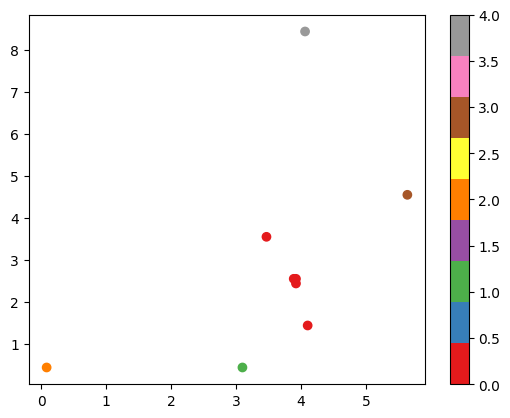

In [54]:
plt.scatter(df["feature1"], df["feature2"], c=labels, cmap="Set1")
plt.colorbar()

In [ ]:
df["mediam_total_num_pixels"] = df["median_num_mine_pixels"] / (df["median_mine_percentage"] / 100)
df

,cid,median_num_mine_pixels,median_mine_percentage,within_aoi_mine_percentage,num_observations,mediam_total_num_pixels
0,0,107418,2.92,11.65,2,3.678699e+06
1,1,13632,0.65,1.91,8,2.097231e+06
2,2,13596,1.34,1.95,15,1.014627e+06
3,3,31424,5.60,9.48,3,5.611429e+05
4,4,10554,1.66,2.09,4,6.357831e+05
5,5,20432,0.72,2.09,9,2.837778e+06
6,6,106921,2.86,9.90,4,3.738497e+06
7,7,92477,2.54,9.11,7,3.640827e+06
8,8,17834,4.05,5.93,7,4.403457e+05


In [ ]:
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt

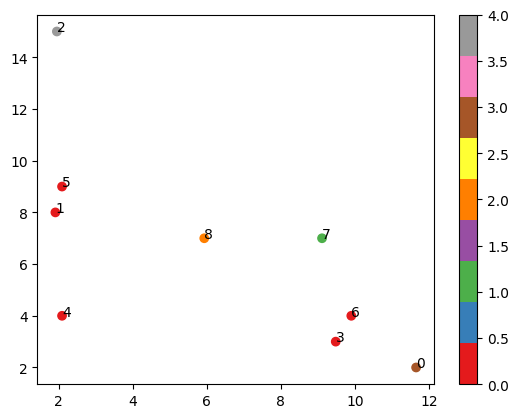

In [53]:
cluster_algo = AgglomerativeClustering(n_clusters=5, linkage="ward", metric="euclidean")
labels = cluster_algo.fit_predict(df[["feature1", "feature2"]])
plt.scatter(df["within_aoi_mine_percentage"], df["num_observations"], c=labels, cmap="Set1")
for cid in df["cid"]:
    plt.text(df.loc[cid, "within_aoi_mine_percentage"], df.loc[cid, "num_observations"], s=cid)
plt.colorbar()

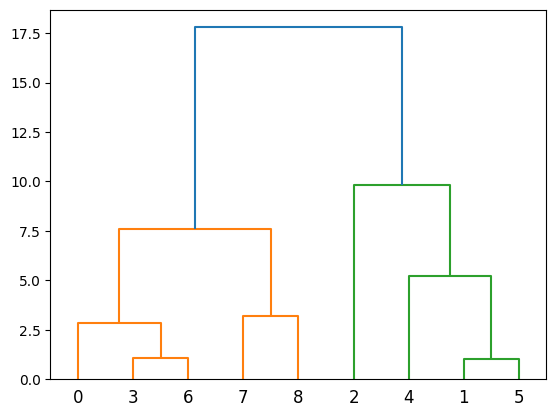

In [29]:
from scipy.cluster.hierarchy import dendrogram, linkage


linkage_data = linkage(df[["within_aoi_mine_percentage", "num_observations"]], method="ward", metric="euclidean")
dendrogram(linkage_data);

In [58]:
df["total_num_pixels"] = (df["num_observations"] * df["mediam_total_num_pixels"]) / 1e6

In [59]:
df

,cid,median_num_mine_pixels,median_mine_percentage,within_aoi_mine_percentage,num_observations,mediam_total_num_pixels,feature1,feature2,total_num_pixels
0,0,107418,2.92,11.65,2,3.678699e+06,5.637778,4.555556,7.357397
1,1,13632,0.65,1.91,8,2.097231e+06,4.102222,1.444444,16.777846
2,2,13596,1.34,1.95,15,1.014627e+06,4.062222,8.444444,15.219403
3,3,31424,5.60,9.48,3,5.611429e+05,3.467778,3.555556,1.683429
4,4,10554,1.66,2.09,4,6.357831e+05,3.922222,2.555556,2.543133
5,5,20432,0.72,2.09,9,2.837778e+06,3.922222,2.444444,25.540000
6,6,106921,2.86,9.90,4,3.738497e+06,3.887778,2.555556,14.953986
7,7,92477,2.54,9.11,7,3.640827e+06,3.097778,0.444444,25.485787
8,8,17834,4.05,5.93,7,4.403457e+05,0.082222,0.444444,3.082420


In [60]:
new_clusters = [
    [7, 8],
    [2],
    [3, 4],
    [0, 1],
    [5, 6]
]